In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data_dir = '/tmp/tensorflow/mnist/input_data'
# Import data
mnist = input_data.read_data_sets(data_dir, one_hot=True)
x_train, x_val = mnist.train.images, mnist.test.images
print("x_train.shape = {}, x_val.shape = {}".format(x_train.shape, x_val.shape))

Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz
x_train.shape = (55000, 784), x_val.shape = (10000, 784)


In [24]:
import tensorflow as tf
def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def bias_variable(shape, name):
    return tf.Variable(tf.constant(0.1, shape = shape), name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

def weight_variable_2(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable_2(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def fc_layer(prev, input_size, output_size):
    W = weight_variable_2([input_size, output_size])
    b = bias_variable_2([output_size])
    return tf.matmul(prev, W) + b

code_dim = 80

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

h_pool2_flat = tf.reshape(h_e_conv2, [-1, 7*7*32])
l1 = tf.nn.relu(fc_layer(h_pool2_flat, 7*7*32, 400))
l2 = fc_layer(l1, 400, code_dim)

code_layer = l2
print("code layer shape : %s" % l2.get_shape())

l3 = tf.nn.relu(fc_layer(l2, code_dim, 400))
l4 = tf.nn.relu(fc_layer(l3, 400, 7*7*32))
l4_re = tf.reshape(l4, [-1, 7, 7, 32])

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1") 
output_shape_d_conv1 = tf.stack([tf.shape(x)[0], 14, 14, 16]) #(batch_size,14,14,16)
h_d_conv1 = tf.nn.relu(deconv2d(l4_re, W_d_conv1, output_shape_d_conv1))
# (?, 7, 7, 32), (5, 5, 16, 32), #(batch_size,14,14,16)

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")
output_shape_d_conv2 = tf.stack([tf.shape(x)[0], 28, 28, 1])
h_d_conv2 = tf.nn.sigmoid(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

x_reconstruct = h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())


code layer shape : (?, 80)
reconstruct layer shape : (?, 28, 28, 1)


In [32]:
loss = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
l_rate = 1e-3
optimizer = tf.train.AdamOptimizer(l_rate).minimize(loss)

total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
#     print(shape)
#     print(len(shape))
    variable_parameters = 1
    for dim in shape:
#         print(dim)
        variable_parameters *= dim.value
#     print(variable_parameters)
    total_parameters += variable_parameters
print("total_parameters = {}".format(total_parameters))

total_parameters = 1347313


In [37]:
init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)
for i in range(50000):
    batch = mnist.train.next_batch(50)
    if i%2000 == 0:
        print("step = %d, val_loss = %g"%(i, loss.eval(feed_dict={x: mnist.test.images})))
    optimizer.run(feed_dict={x: batch[0]})

print("final loss val %g" % loss.eval(feed_dict={x: mnist.test.images}))

C:\Users\USER\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step = 0, val_loss = 0.285457
step = 2000, val_loss = 0.00465252
step = 4000, val_loss = 0.00335003
step = 6000, val_loss = 0.00292179
step = 8000, val_loss = 0.0024305
step = 10000, val_loss = 0.00221568
step = 12000, val_loss = 0.00215442
step = 14000, val_loss = 0.00206829
step = 16000, val_loss = 0.00189123
step = 18000, val_loss = 0.00188551
step = 20000, val_loss = 0.00179395
step = 22000, val_loss = 0.00174556
step = 24000, val_loss = 0.00178871
step = 26000, val_loss = 0.00171858
step = 28000, val_loss = 0.00167248
step = 30000, val_loss = 0.0016522
step = 32000, val_loss = 0.00160544
step = 34000, val_loss = 0.00159874
step = 36000, val_loss = 0.00162819
step = 38000, val_loss = 0.00162092
step = 40000, val_loss = 0.00155151
step = 42000, val_loss = 0.00173392
step = 44000, val_loss = 0.00156586
step = 46000, val_loss = 0.00151439
step = 48000, val_loss = 0.00156541
final loss val 0.0016292


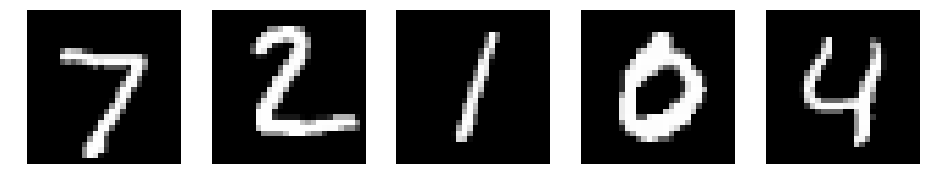

original mnist validation data


In [40]:
import matplotlib.pyplot as plt
fig_num = 5
plt.subplots(figsize=(16,16))
for i in range(fig_num):
    plt.subplot(1,fig_num,i+1)
    plt.imshow(x_val[i].reshape(28,28), cmap='Greys_r')
    plt.axis('off')
plt.show()
print("original mnist validation data")

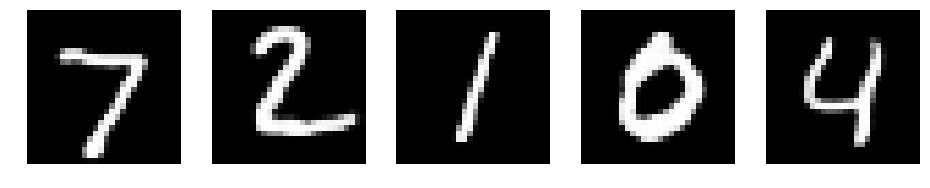

cnn reconstruct mnist validation data


In [41]:
import numpy as np
output_dec = x_reconstruct.eval(feed_dict = {x: mnist.test.images})
output_dec_clip = np.clip(output_dec,0,1)
plt.subplots(figsize=(16,16))
for i in range(fig_num):
    plt.subplot(1,fig_num,i+1)
    plt.imshow(output_dec_clip[i].reshape(28,28), cmap='Greys_r')
    plt.axis('off')
plt.show()
print("cnn reconstruct mnist validation data")